<a href="https://colab.research.google.com/github/Spocklight/Data_Mining_Bases/blob/main/Ejerciciopropuesto_ModuloTextMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Funciones de carga y preparación de datos

In [2]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob). 
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [3]:
import sys
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re  
!{sys.executable} -m pip install contractions
import contractions 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Eliminamos los mensajes de "futurewarnings"

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.3 MB/s 
     |████████████████████████████████| 106 kB 71.5 MB/s 


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [4]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [5]:
datos_ejercicio.head(4)


,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


In [6]:
type(datos_ejercicio)

pandas.core.frame.DataFrame

In [7]:
texto_tweets = datos_ejercicio["tweet_text"].to_list()
print(type(texto_tweets))

<class 'list'>


## 2. Análisis exploratorio

In [8]:
datos_ejercicio.dtypes


tweet_id       int64
tweet_text    object
label          int64
set           object
dtype: object

In [9]:
print("Tenemos un conjunto de {} documentos".format(len(datos_ejercicio)))


Tenemos un conjunto de 8000 documentos


In [10]:
display(datos_ejercicio["label"].value_counts(normalize=True)*100)

0    76.625
1    23.375
Name: label, dtype: float64

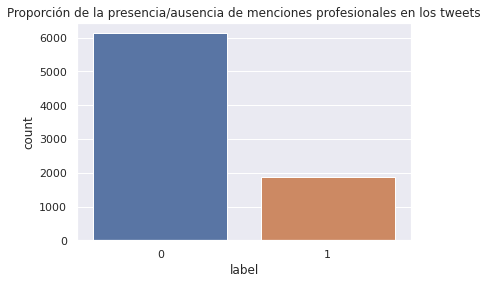

In [11]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data = datos_ejercicio).set(title='Proporción de la presencia/ausencia de menciones profesionales en los tweets')

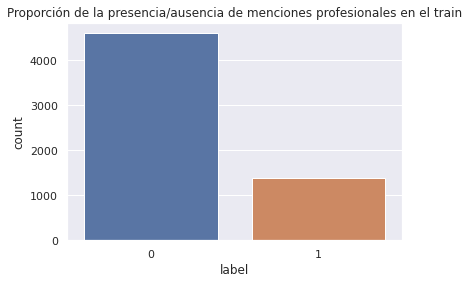

In [12]:
ax = sns.countplot(x="label", data = datos_ejercicio[datos_ejercicio.set=="train"]).set(title='Proporción de la presencia/ausencia de menciones profesionales en el train')

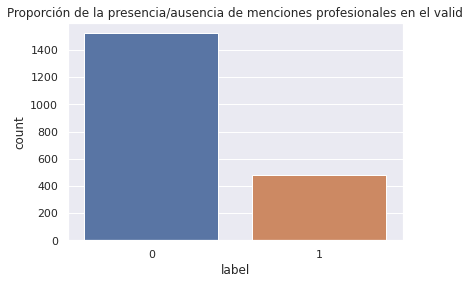

In [13]:
ax = sns.countplot(x="label", data = datos_ejercicio[datos_ejercicio.set=="valid"]).set(title='Proporción de la presencia/ausencia de menciones profesionales en el valid')

In [14]:
display(datos_ejercicio["set"].value_counts(normalize=True)*100)

train    75.0
valid    25.0
Name: set, dtype: float64

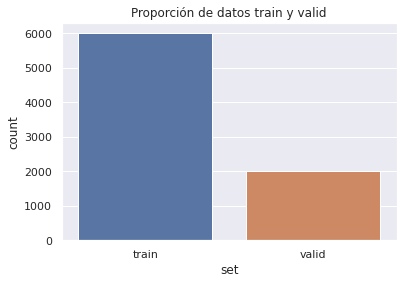

In [15]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="set", data = datos_ejercicio).set(title='Proporción de datos train y valid')

In [16]:
print("Existen {} noticias duplicadas".format(np.sum(datos_ejercicio.duplicated(subset=["tweet_text"])))) 

Existen 0 noticias duplicadas


In [17]:

print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(datos_ejercicio.isnull())[0],
                                                                                                        np.sum(datos_ejercicio.isnull())[1])) 

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


In [18]:
np.sum(datos_ejercicio.isnull())

tweet_id      0
tweet_text    0
label         0
set           0
dtype: int64

In [19]:
dataset = datos_ejercicio
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

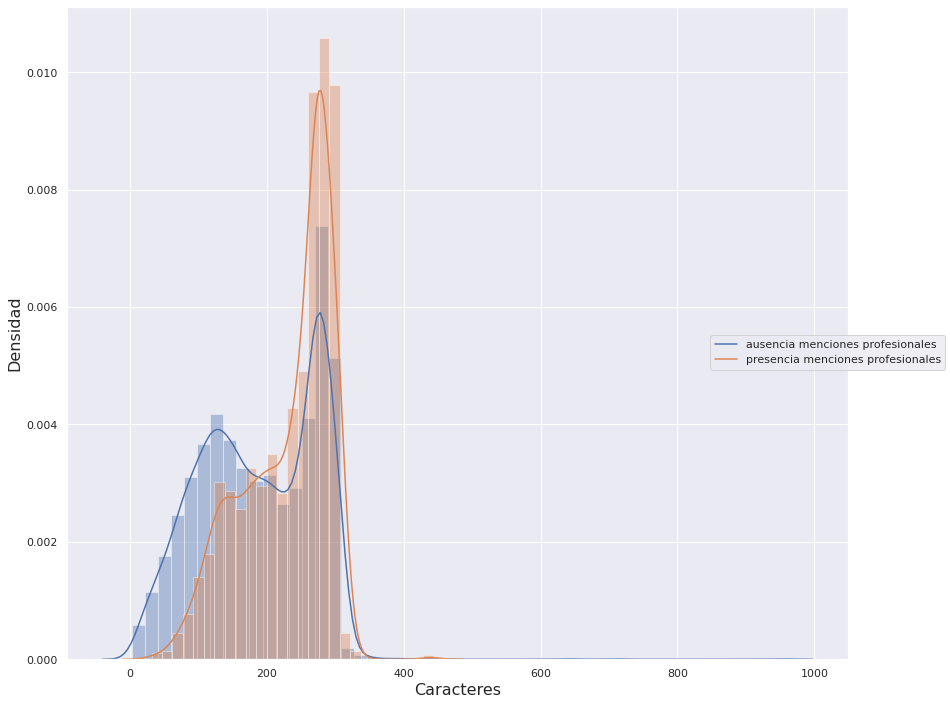

In [20]:
fig = plt.figure(figsize=(14,12))

plt1 = sns.distplot(dataset[dataset.label==0].char_len, hist=True, label="ausencia menciones profesionales")
plt2 = sns.distplot(dataset[dataset.label==1].char_len, hist=True, label="presencia menciones profesionales")
fig.legend(labels=['ausencia menciones profesionales','presencia menciones profesionales'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

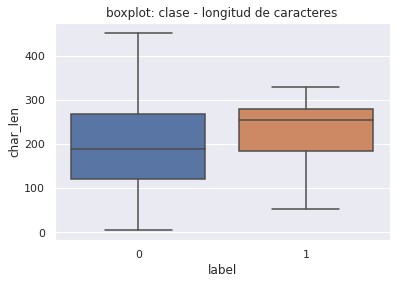

In [21]:
ax = sns.boxplot(x="label", y="char_len", data=dataset, showfliers = False)
ax.set_title("boxplot: clase - longitud de caracteres")
plt.show()

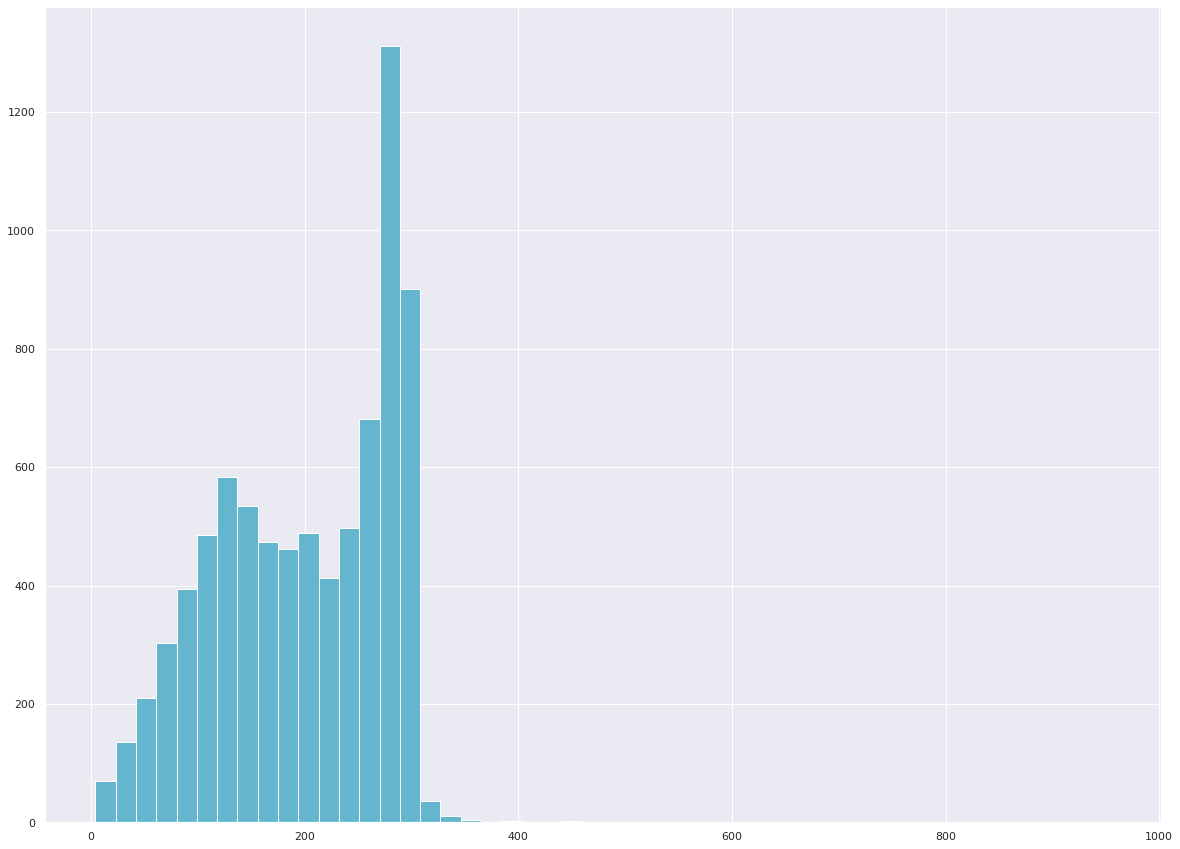

In [22]:
dataset["char_len"].hist(bins=50, figsize=(20,15), color="c")   
plt.show()

Número de tweets con label=0 de una extensión superior a 700 caracteres:  2


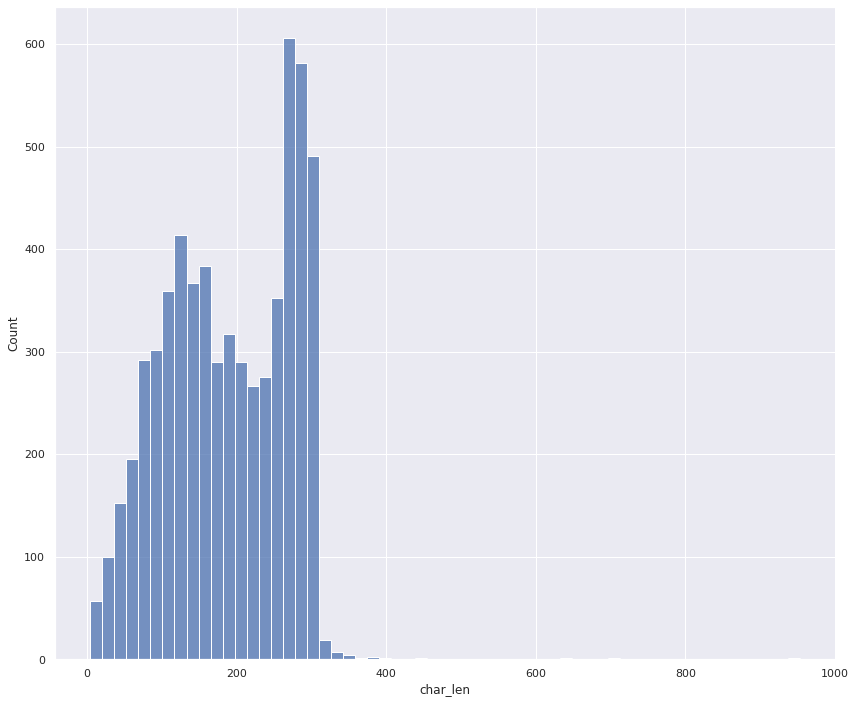

In [23]:
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(14,12))
sns.histplot(data=dataset[dataset.label==0], x="char_len")

count = (dataset[dataset.label==0]["char_len"] > 700).sum()
print('Número de tweets con label=0 de una extensión superior a 700 caracteres: ', count)

Número de tweets con label=0 de una extensión superior a 500 caracteres:  0


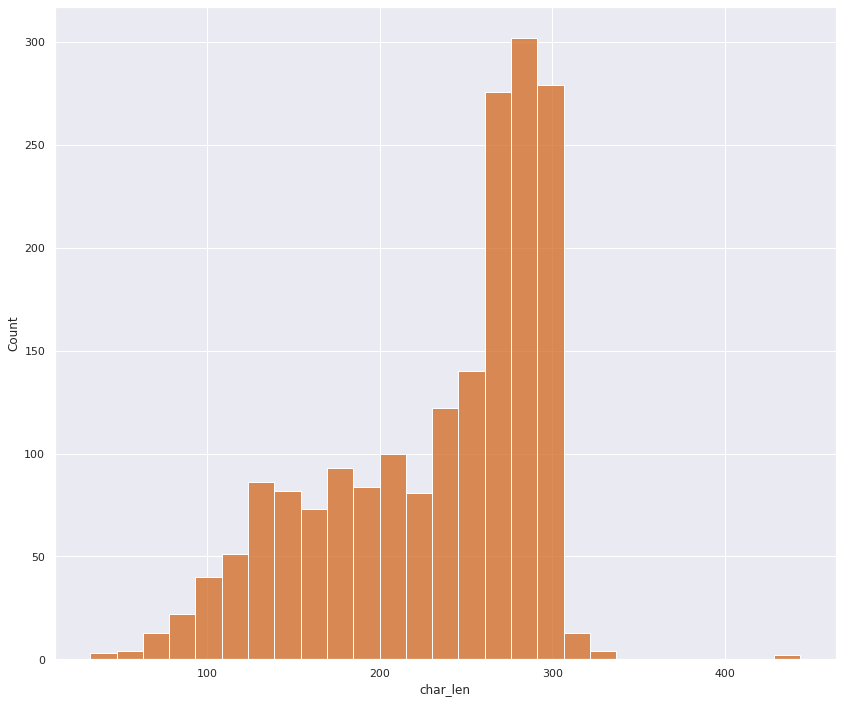

In [24]:
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(14,12))
sns.histplot(data=dataset[dataset.label==1], x="char_len", color="chocolate")

count = (dataset[dataset.label==1]["char_len"] > 500).sum()
print('Número de tweets con label=0 de una extensión superior a 500 caracteres: ', count)

In [25]:
def count_upper_case_letters(str_obj):
    count = 0
    for elem in str_obj:
        if elem.isupper():
            count += 1
    return count

In [26]:
dataset["prop_uppercase"] = dataset["tweet_text"].apply(lambda x: count_upper_case_letters(x)/len(x))


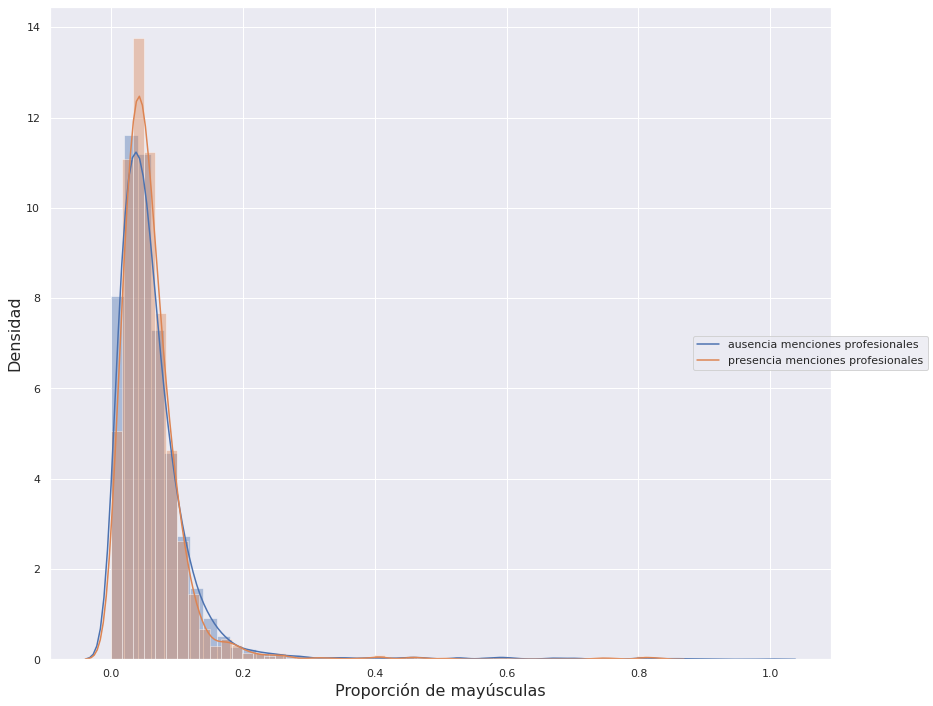

In [27]:
fig = plt.figure(figsize=(14,12))

plt1 = sns.distplot(dataset[dataset.label==0].prop_uppercase, hist=True, label="ausencia menciones profesionales")
plt2 = sns.distplot(dataset[dataset.label==1].prop_uppercase, hist=True, label="presencia menciones profesionales")
fig.legend(labels=['ausencia menciones profesionales','presencia menciones profesionales'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Proporción de mayúsculas', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [28]:
def string_k(k, str):
     
    string = []
    text = str.split(" ")
    
    for x in text:
         x = ''.join([i for i in x if not i.isdigit()])
         x = re.sub(r'[^\w]', ' ', x)
         if len(x) > k:

             string.append(x)
             
    return len(set(string))/len(text)

In [29]:
dataset["prop_long"] = dataset["tweet_text"].apply(lambda x: string_k(7, x))

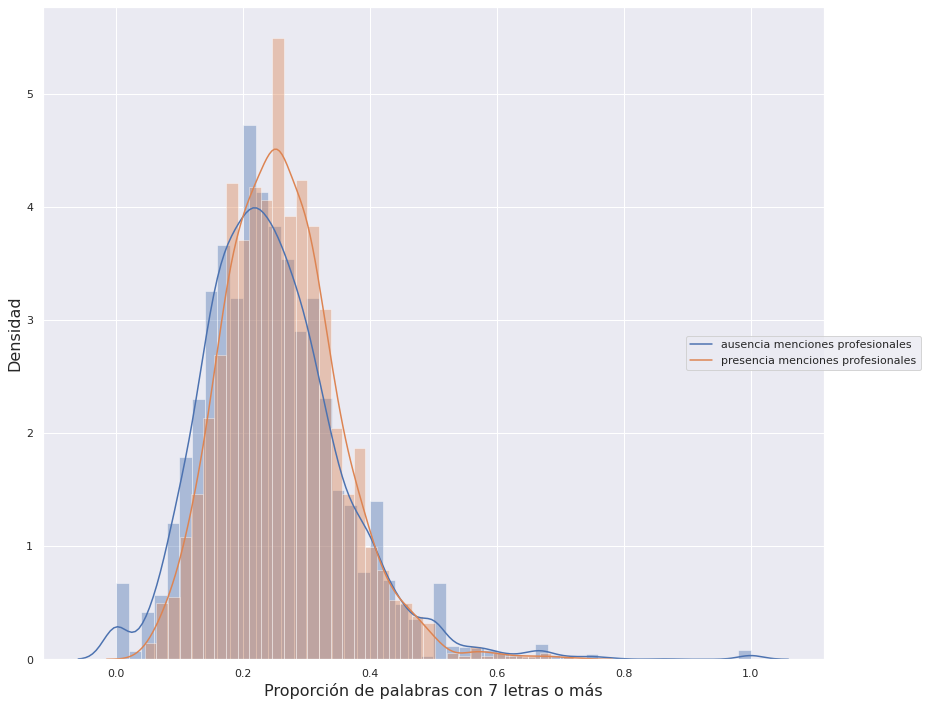

In [30]:
fig = plt.figure(figsize=(14,12))

plt1 = sns.distplot(dataset[dataset.label==0].prop_long, hist=True, label="ausencia menciones profesionales")
plt2 = sns.distplot(dataset[dataset.label==1].prop_long, hist=True, label="presencia menciones profesionales")
fig.legend(labels=['ausencia menciones profesionales','presencia menciones profesionales'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Proporción de palabras con 7 letras o más', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

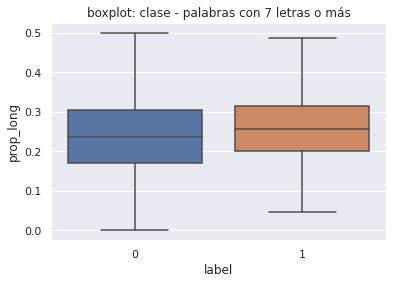

In [31]:
ax = sns.boxplot(x="label", y="prop_long", data=dataset, showfliers = False)
ax.set_title("boxplot: clase - palabras con 7 letras o más")
plt.show()

## 3. Preprocesado y Normalización

In [32]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split())   #"".join(input) devuelve el input como un string. Por ejemplo una lista la pasa a string.

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador
from nltk import word_tokenize
def tokenization(text):
  tokens = word_tokenize(text)
  return tokens

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('spanish')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

# Lemmatization

import string 
from nltk.stem import PorterStemmer   
stemmer = PorterStemmer() 
def stem(tokens): 
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens

In [33]:
# Quitar Espacios
dataset["norm"] = dataset["tweet_text"].apply(lambda x: eliminar_espacios(x))
# To Lower
dataset["norm"] = dataset["norm"].apply(lambda x: texto_to_lower(x))
# Contraciones
dataset["norm"] = dataset["norm"].apply(lambda x: replace_contraction(x))
# Tokenizar
dataset["norm"] = dataset["norm"].apply(lambda x: tokenization(x))
# Quitar Stopwords
dataset["norm"] = dataset["norm"].apply(lambda x: quitar_stopwords(x))
# Quitar puntuación
dataset["norm"] = dataset["norm"].apply(lambda x: quitar_puntuacion(x))
# Stemming
dataset["norm"] = dataset["norm"].apply(lambda x: stem(x))

In [34]:
dataset["norm"][4]

['si',
 'confinamiento',
 'dejado',
 'tocada',
 'estabilidad',
 'mental',
 'siempr',
 'pued',
 'consolart',
 'pensando',
 'miguel',
 'bosé',
 'quedado',
 'peor']

In [35]:
dataset["clean_text"] = dataset["norm"].apply(lambda x: " ".join(x))

In [36]:
dataset["clean_text"][4]


'si confinamiento dejado tocada estabilidad mental siempr pued consolart pensando miguel bosé quedado peor'

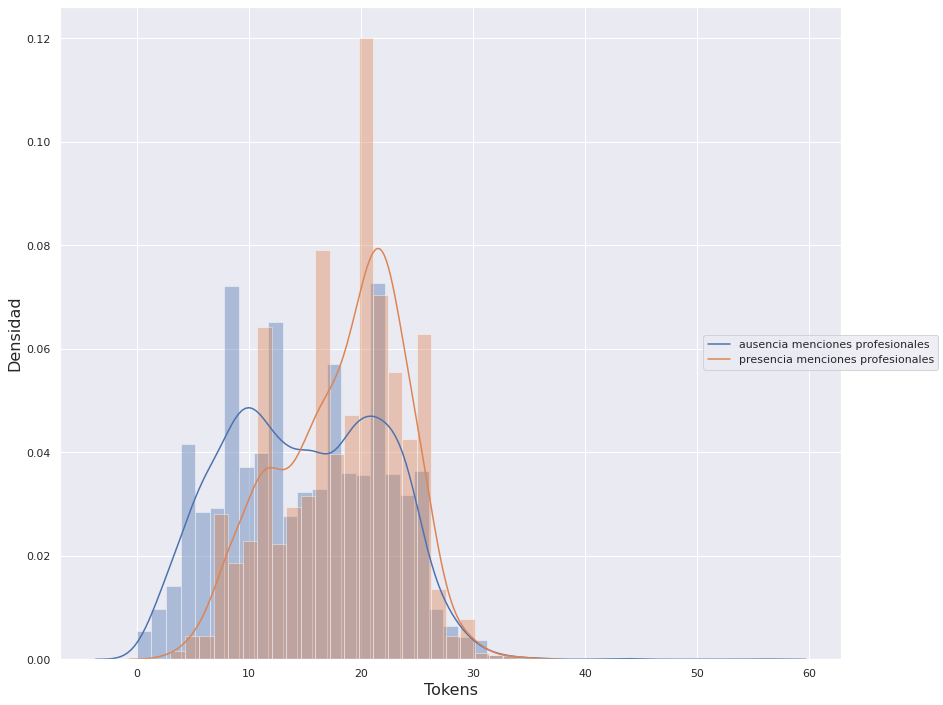

In [37]:
dataset["token_len"] = dataset["norm"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))

plt1 = sns.distplot(dataset[dataset.label==0].token_len, hist=True, label="ausencia menciones profesionales")
plt2 = sns.distplot(dataset[dataset.label==1].token_len, hist=True, label="presencia menciones profesionales")
fig.legend(labels=['ausencia menciones profesionales','presencia menciones profesionales'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Tokens', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

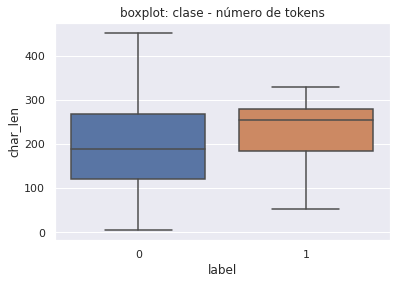

In [38]:
ax = sns.boxplot(x="label", y="char_len", data=dataset, showfliers = False)
ax.set_title("boxplot: clase - número de tokens")
plt.show()

In [39]:
dataset["prop_token_long"] = dataset["clean_text"].apply(lambda x: string_k(6, x))

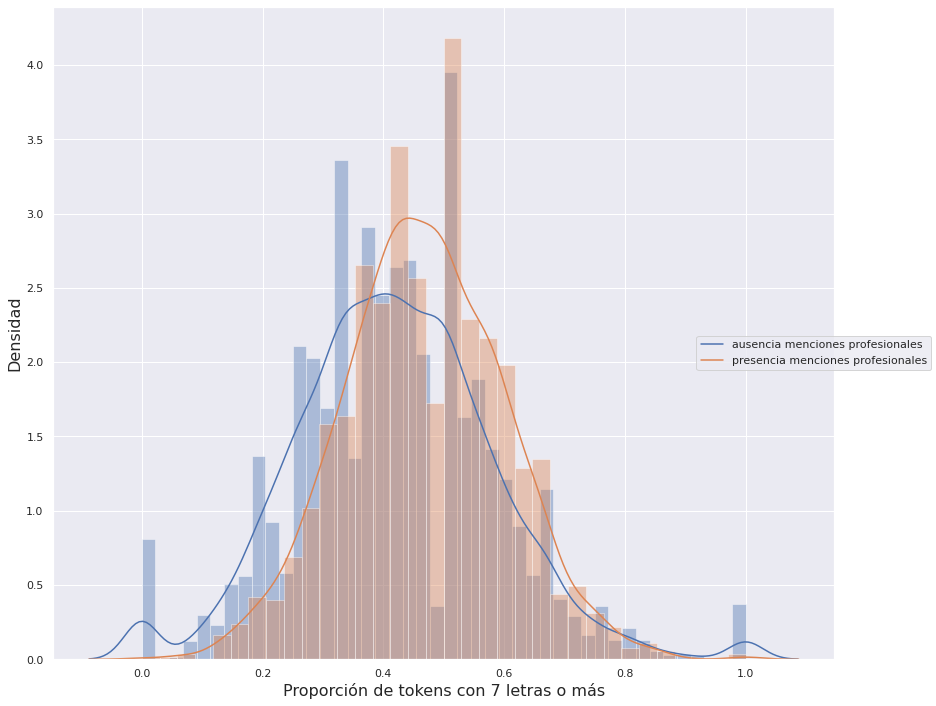

In [40]:
fig = plt.figure(figsize=(14,12))

plt1 = sns.distplot(dataset[dataset.label==0].prop_token_long, hist=True, label="ausencia menciones profesionales")
plt2 = sns.distplot(dataset[dataset.label==1].prop_token_long, hist=True, label="presencia menciones profesionales")
fig.legend(labels=['ausencia menciones profesionales','presencia menciones profesionales'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Proporción de tokens con 7 letras o más', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

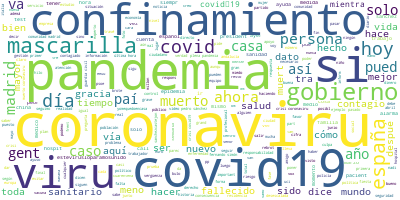

In [41]:
datawords = list()

for i in dataset["norm"]: # iteramos sobre la lista de "text_procesed" del dataset2 
  datawords.append(i)

import itertools
datawords= list(itertools.chain.from_iterable(datawords))

from wordcloud import WordCloud
long_string = ','.join([str(item) for item in datawords])
wordcloud_new = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
wordcloud_new.generate(long_string)
wordcloud_new.to_image()


## 4. Vectorización

In [42]:
train = dataset[dataset.set=="train"]
test = dataset[dataset.set=="valid"]

vectorizador = TfidfVectorizer(max_features=30,                  
                               ngram_range=(1,3),
                               min_df=0.01,
                               lowercase=False)

vector_data_train = vectorizador.fit_transform(train["clean_text"])
vector_data_test = vectorizador.fit_transform(test["clean_text"])

## 5. Entrenamiento y evaluación de modelos


In [43]:
print(dataset.columns)

Index(['tweet_id', 'tweet_text', 'label', 'set', 'char_len', 'prop_uppercase',
       'prop_long', 'norm', 'clean_text', 'token_len', 'prop_token_long'],
      dtype='object')


In [44]:
import scipy as sp

extra_features_train = train[["char_len", "prop_uppercase", "prop_long", "token_len", "prop_token_long"]]
extra_features_test = test[["char_len", "prop_uppercase", "prop_long", "token_len", "prop_token_long"]]

y_train = train["label"].values.astype(np.float32)
X_train = sp.sparse.hstack((vector_data_train, extra_features_train.values),format='csr')

y_test = test["label"].values.astype(np.float32)
X_test = sp.sparse.hstack((vector_data_test, extra_features_test.values),format='csr')


In [45]:
X_columns=vectorizador.get_feature_names()+extra_features_train.columns.tolist()
X_columns

['ahora',
 'caso',
 'confinamiento',
 'contagio',
 'coronaviru',
 'coronaviru http',
 'covid',
 'covid19',
 'crisi',
 'día',
 'españa',
 'fallecido',
 'gestión',
 'gobierno',
 'hace',
 'hacer',
 'hoy',
 'http',
 'http http',
 'madrid',
 'mascarilla',
 'muerto',
 'nuevo',
 'pandemia',
 'persona',
 'pued',
 'si',
 'sánchez',
 'va',
 'viru',
 'char_len',
 'prop_uppercase',
 'prop_long',
 'token_len',
 'prop_token_long']

In [46]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #Para cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98) #Provides train/test indices to split data in train/test sets

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
          ("Logistic",LogisticRegression(random_state=30)),
          ("DecisionTree", DecisionTreeClassifier()),
          ("GaussianNB",GaussianNB())
]

evaluation_score = "accuracy"
model_evaluation(models,  evaluation_score, X_train.toarray(), y_train)   

Metric: accuracy , KFold 
Logistic: 0.766333 (0.009967) 
Metric: accuracy , KFold 
DecisionTree: 0.656167 (0.018842) 
Metric: accuracy , KFold 
GaussianNB: 0.638167 (0.024568) 


([array([0.77333333, 0.76      , 0.75166667, 0.76333333, 0.79      ,
         0.76833333, 0.77      , 0.76666667, 0.75666667, 0.76333333]),
  array([0.65666667, 0.675     , 0.65333333, 0.69333333, 0.63833333,
         0.66166667, 0.64666667, 0.65333333, 0.66333333, 0.62      ]),
  array([0.63666667, 0.63333333, 0.62      , 0.655     , 0.63333333,
         0.62      , 0.62      , 0.68      , 0.60333333, 0.68      ])],
 ['Logistic', 'DecisionTree', 'GaussianNB'])

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [49]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [50]:
grid_result = grid_search.fit(X_train, y_train)
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.767500 usando los parámetros {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [51]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=0.01, penalty="l2", solver = "liblinear")
model.fit(X_train,y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [53]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1522    1]
 [ 477    0]]
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1523
         1.0       0.00      0.00      0.00       477

    accuracy                           0.76      2000
   macro avg       0.38      0.50      0.43      2000
weighted avg       0.58      0.76      0.66      2000



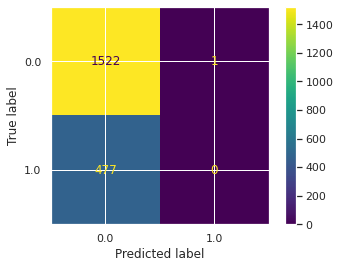

In [54]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize = None)

In [55]:
importance = model.coef_[0]
importance

array([-0.08080791, -0.07712222, -0.11875081, -0.1110168 , -0.01004995,
       -0.06125792,  0.02827324, -0.10521257, -0.00717887, -0.00530828,
       -0.04555949, -0.10899372,  0.03487024, -0.11106621,  0.01948775,
       -0.00843455, -0.13473124, -0.05860768,  0.00568628, -0.25382468,
       -0.06152564, -0.08343875, -0.12243768,  0.05837031, -0.0546013 ,
       -0.01577798, -0.03204901, -0.13354454,  0.02227285, -0.14520524,
        0.00511074, -0.10730085, -0.20517019, -0.03051087, -0.16284077])

Feature: 0, Name: ahora , Score: -0.08081
Feature: 1, Name: caso , Score: -0.07712
Feature: 2, Name: confinamiento , Score: -0.11875
Feature: 3, Name: contagio , Score: -0.11102
Feature: 4, Name: coronaviru , Score: -0.01005
Feature: 5, Name: coronaviru http , Score: -0.06126
Feature: 6, Name: covid , Score: 0.02827
Feature: 7, Name: covid19 , Score: -0.10521
Feature: 8, Name: crisi , Score: -0.00718
Feature: 9, Name: día , Score: -0.00531
Feature: 10, Name: españa , Score: -0.04556
Feature: 11, Name: fallecido , Score: -0.10899
Feature: 12, Name: gestión , Score: 0.03487
Feature: 13, Name: gobierno , Score: -0.11107
Feature: 14, Name: hace , Score: 0.01949
Feature: 15, Name: hacer , Score: -0.00843
Feature: 16, Name: hoy , Score: -0.13473
Feature: 17, Name: http , Score: -0.05861
Feature: 18, Name: http http , Score: 0.00569
Feature: 19, Name: madrid , Score: -0.25382
Feature: 20, Name: mascarilla , Score: -0.06153
Feature: 21, Name: muerto , Score: -0.08344
Feature: 22, Name: nuevo ,

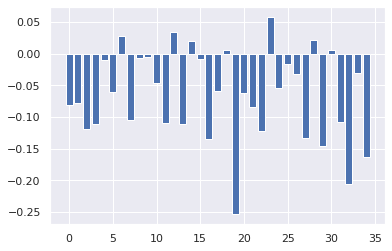

In [56]:
for i,v in enumerate(importance):
 print('Feature: %0d, Name: %s , Score: %.5f' % (i,X_columns[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()